**Ideas for future**

Immediate:

- Finish transporting all features from Data 2 - Main
- Train 

Future:

- Small test hypotheses & Grid Search
- Implement Ana's idea*
- Alternate strategy: don't predict dT, but the alternatives in Presentation Notes 2

For now, I will try to predict $dT = T_{zero} - T_{zc}$ based on the coefficients $a_0$ etc. and $\chi^2$. 

In [1]:
#--- Preamble

# Visualizers
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150   # Increase figure resolution
plt.rcParams['savefig.dpi'] = 150

# Data computation and manipulation
import numpy as np
import pandas as pd
import scipy.optimize as sop
import scipy.stats as sps

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.random.set_seed(42)  # Set seed - reproducibility

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# For permutations
import itertools

In [8]:
#-> Paths to access saved models on my different machines

paths_on_my_laptop = ["C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/MLdata_Po3CFD.dat",
                     "C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/Saved Models/"]

#-> Read the data
# Note: There is an extra redundant column to drop

# Import
path_temp = paths_on_my_laptop[0]
data = pd.read_csv(path_temp, sep=",").drop(columns=["Ch"])

# Create column dT = T_zero - T_zc
data["dT"] = data["T_zero"] - data["T_zc"]

# Filter for only the energies in the peak
FILTER_ENERGIES = True

if FILTER_ENERGIES == True:
    data = data[(data["E"] > 4490) & (data["E"] < 4570)]

# Visualize and prepare data

**Conclusions**

*Unfiltered data-set*

- From scatter plots: the structure is somewhat boring (vertical stripe = thin uncorrelated Gaussian), which doesn't help with the predictive power. There is, however, a bump around the high values that may help. The most "interesting" covariates are, from most to least: $a_3 \approx a_2$, $a_0$, $a_1$, $\chi^2$.
- From the correlation matrix: the covariates are, from best to worst: $a_3$, $a_2$, $a_0 \approx \chi^2$, $a_1$. This is pretty consistent with our findings above.

*Filtered data-set*

The number of data points drops from $6000$ to around $2000$. However, the quality of the set seems to be much better; quality = "interestingness" of features. 

- From the scatter plots: the structure is non-linear and non-gaussian, with the distribution between $dT$ and 'a' coefficients having a crescent shape -> a lot of non-linearity to exploit from the data set. The covariates are, from best to worst: $a_3 \sim a_2$ (best ones), $a_1$ (close to the first two), $\chi^2 > \sim a_0$ (uncorrelated gaussian with some smear. If we can afford it, we should test for dropping these covariates to obtain the sparsest model - by cross-validation?).
- From the correlation matrices: the correlations support our assessment above. They are overall significantly larger than the ones for the unfiltered data set.

In [11]:
data.head()

,E,T_zero,T_zc,a0,a1,a2,a3,dTime,chi2,dT
2,4543,56.0142,180.400,0.002568,-0.000060,-0.000048,0.000003,-52.4072,0.000037,-124.3858
4,4511,42.1653,165.936,0.002186,-0.000863,-0.000016,0.000004,-41.5207,0.000029,-123.7707
5,4528,50.2036,171.218,0.002894,-0.000323,-0.000063,0.000004,-46.6069,0.000027,-121.0144
7,4529,61.4468,180.298,-0.008945,0.002719,-0.000286,0.000009,-58.9355,0.000026,-118.8512
10,4520,46.5472,171.166,0.001290,0.000296,-0.000109,0.000005,-42.9064,0.000012,-124.6188


In [9]:
data.shape

(1991, 10)

In [10]:
data.columns

Index(['E', 'T_zero', 'T_zc', 'a0', 'a1', 'a2', 'a3', 'dTime', 'chi2', 'dT'], dtype='object')

## Scatter Plots and Histograms

**Scatter Matrix** (from Pandas)

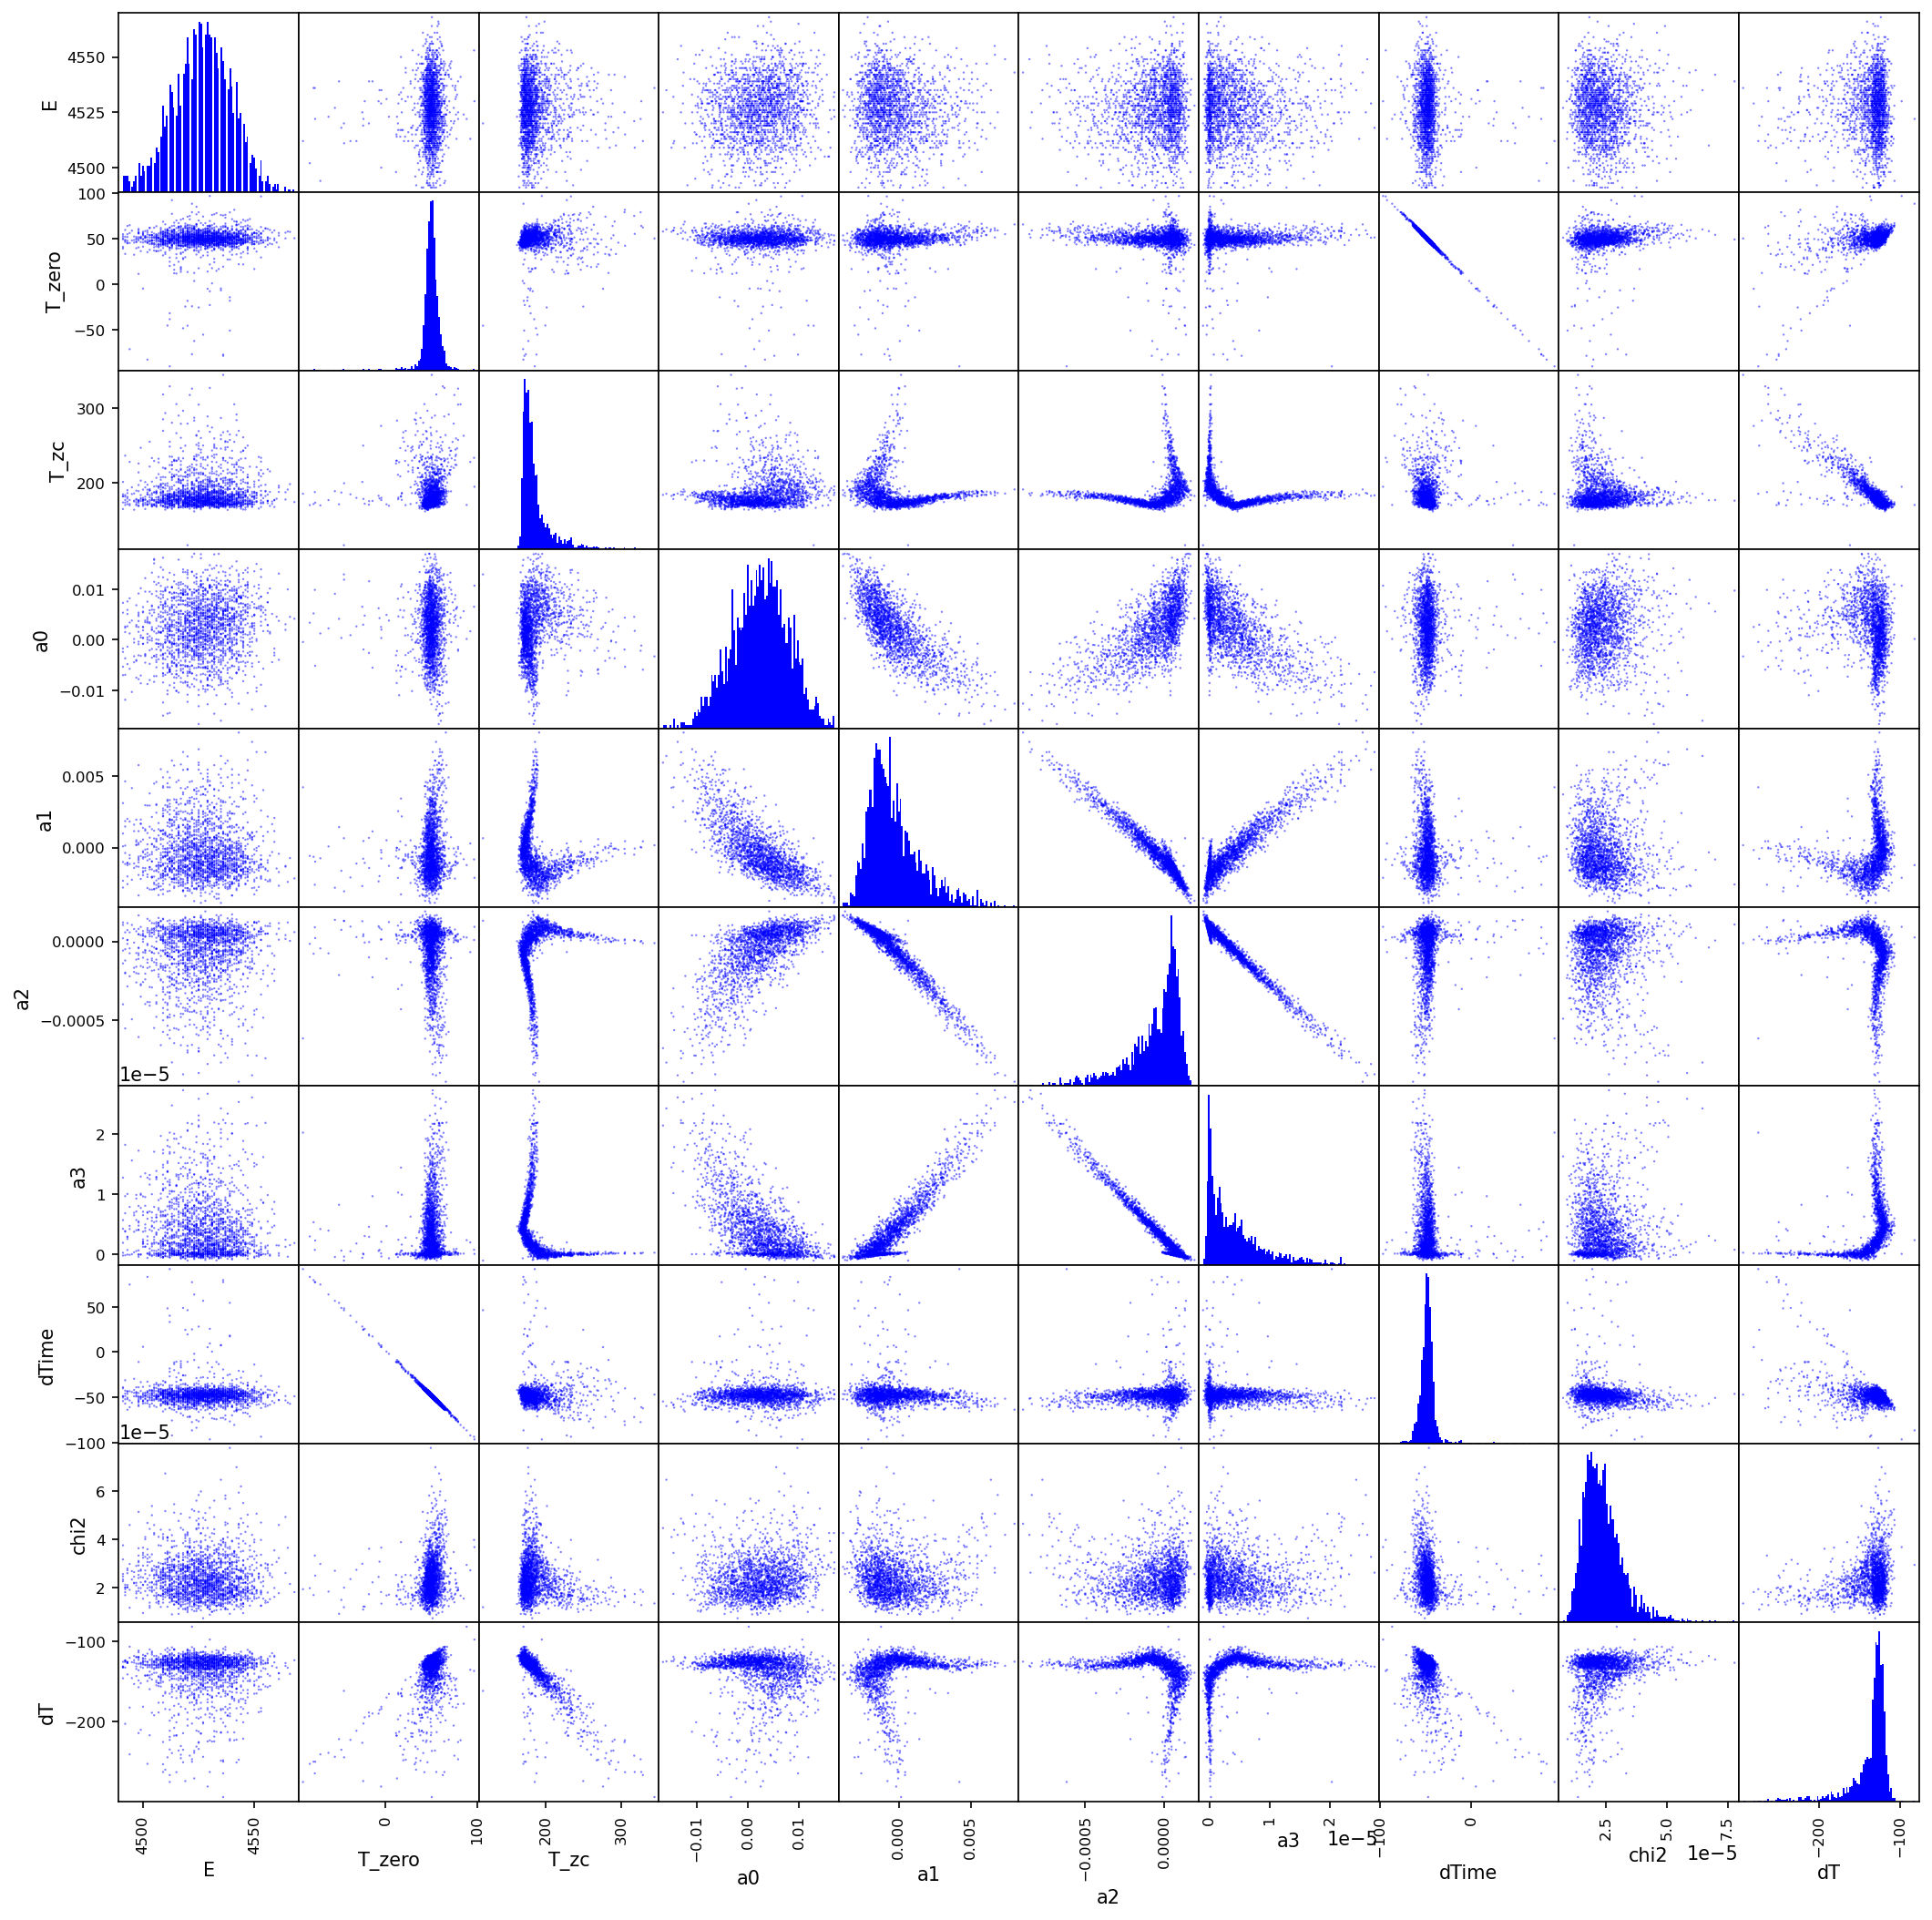

In [12]:
pd.plotting.scatter_matrix(data, color='blue', figsize=(17, 17), s=5,
                          hist_kwds={'bins':100, 'color':'blue'})

# Save and show nicely
if FILTER_ENERGIES == True:
    plt.savefig('Scatter matrix - energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Scatter matrix - unfiltered.png', bbox_inches='tight')

plt.show()

**Scatter Plots** (custom made)

In [13]:
def scatter_matrix_plotter(indices_1, indices_2, save_fig=False):
    """
    Creates a scatter mattrix plot of each feature given by
    indices_1 and indices_2.
    
    --- Inputs:
    
    indices_1, indices_2 = Array-like. Each contains a list of all index_1, 
    respectively index_2 arguments, which represent the names of the columns 
    that are to be plotted by df.plot.scatter(). 
    **Note**:Both must have the same length!
    
    save_fig = Boolean. If true, it saves the subplots as a PNG
    
    --- Returns:
    
    A subplot with all scatter plots required.
    """
    
    num_rows = max(len(indices_1) // 3, 1)
    
    fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

    for index_1, index_2, ax in zip(indices_1, indices_2, axs.flatten()):
        ax.scatter(data[index_1], data[index_2], s=5, c="blue")
        ax.set_title(f"{index_2} vs. {index_1}")
        
        ax.set_xlabel(index_1, fontsize=12)
        ax.set_ylabel(index_2, fontsize=12)
    
    if FILTER_ENERGIES == True:
        fig.suptitle('Scatter plot of multiple features - energy filtered', size=38)
    else:
        fig.suptitle('Scatter plot of multiple features - unfiltered', size=38)
        
    if save_fig == True:
        if FILTER_ENERGIES == True:
            plt.savefig('Scatter plots of multiple features - energy filtered.png', bbox_inches='tight')
        else:
            plt.savefig('Scatter plots of multiple features - unfiltered.png', bbox_inches='tight')
    
    plt.show()

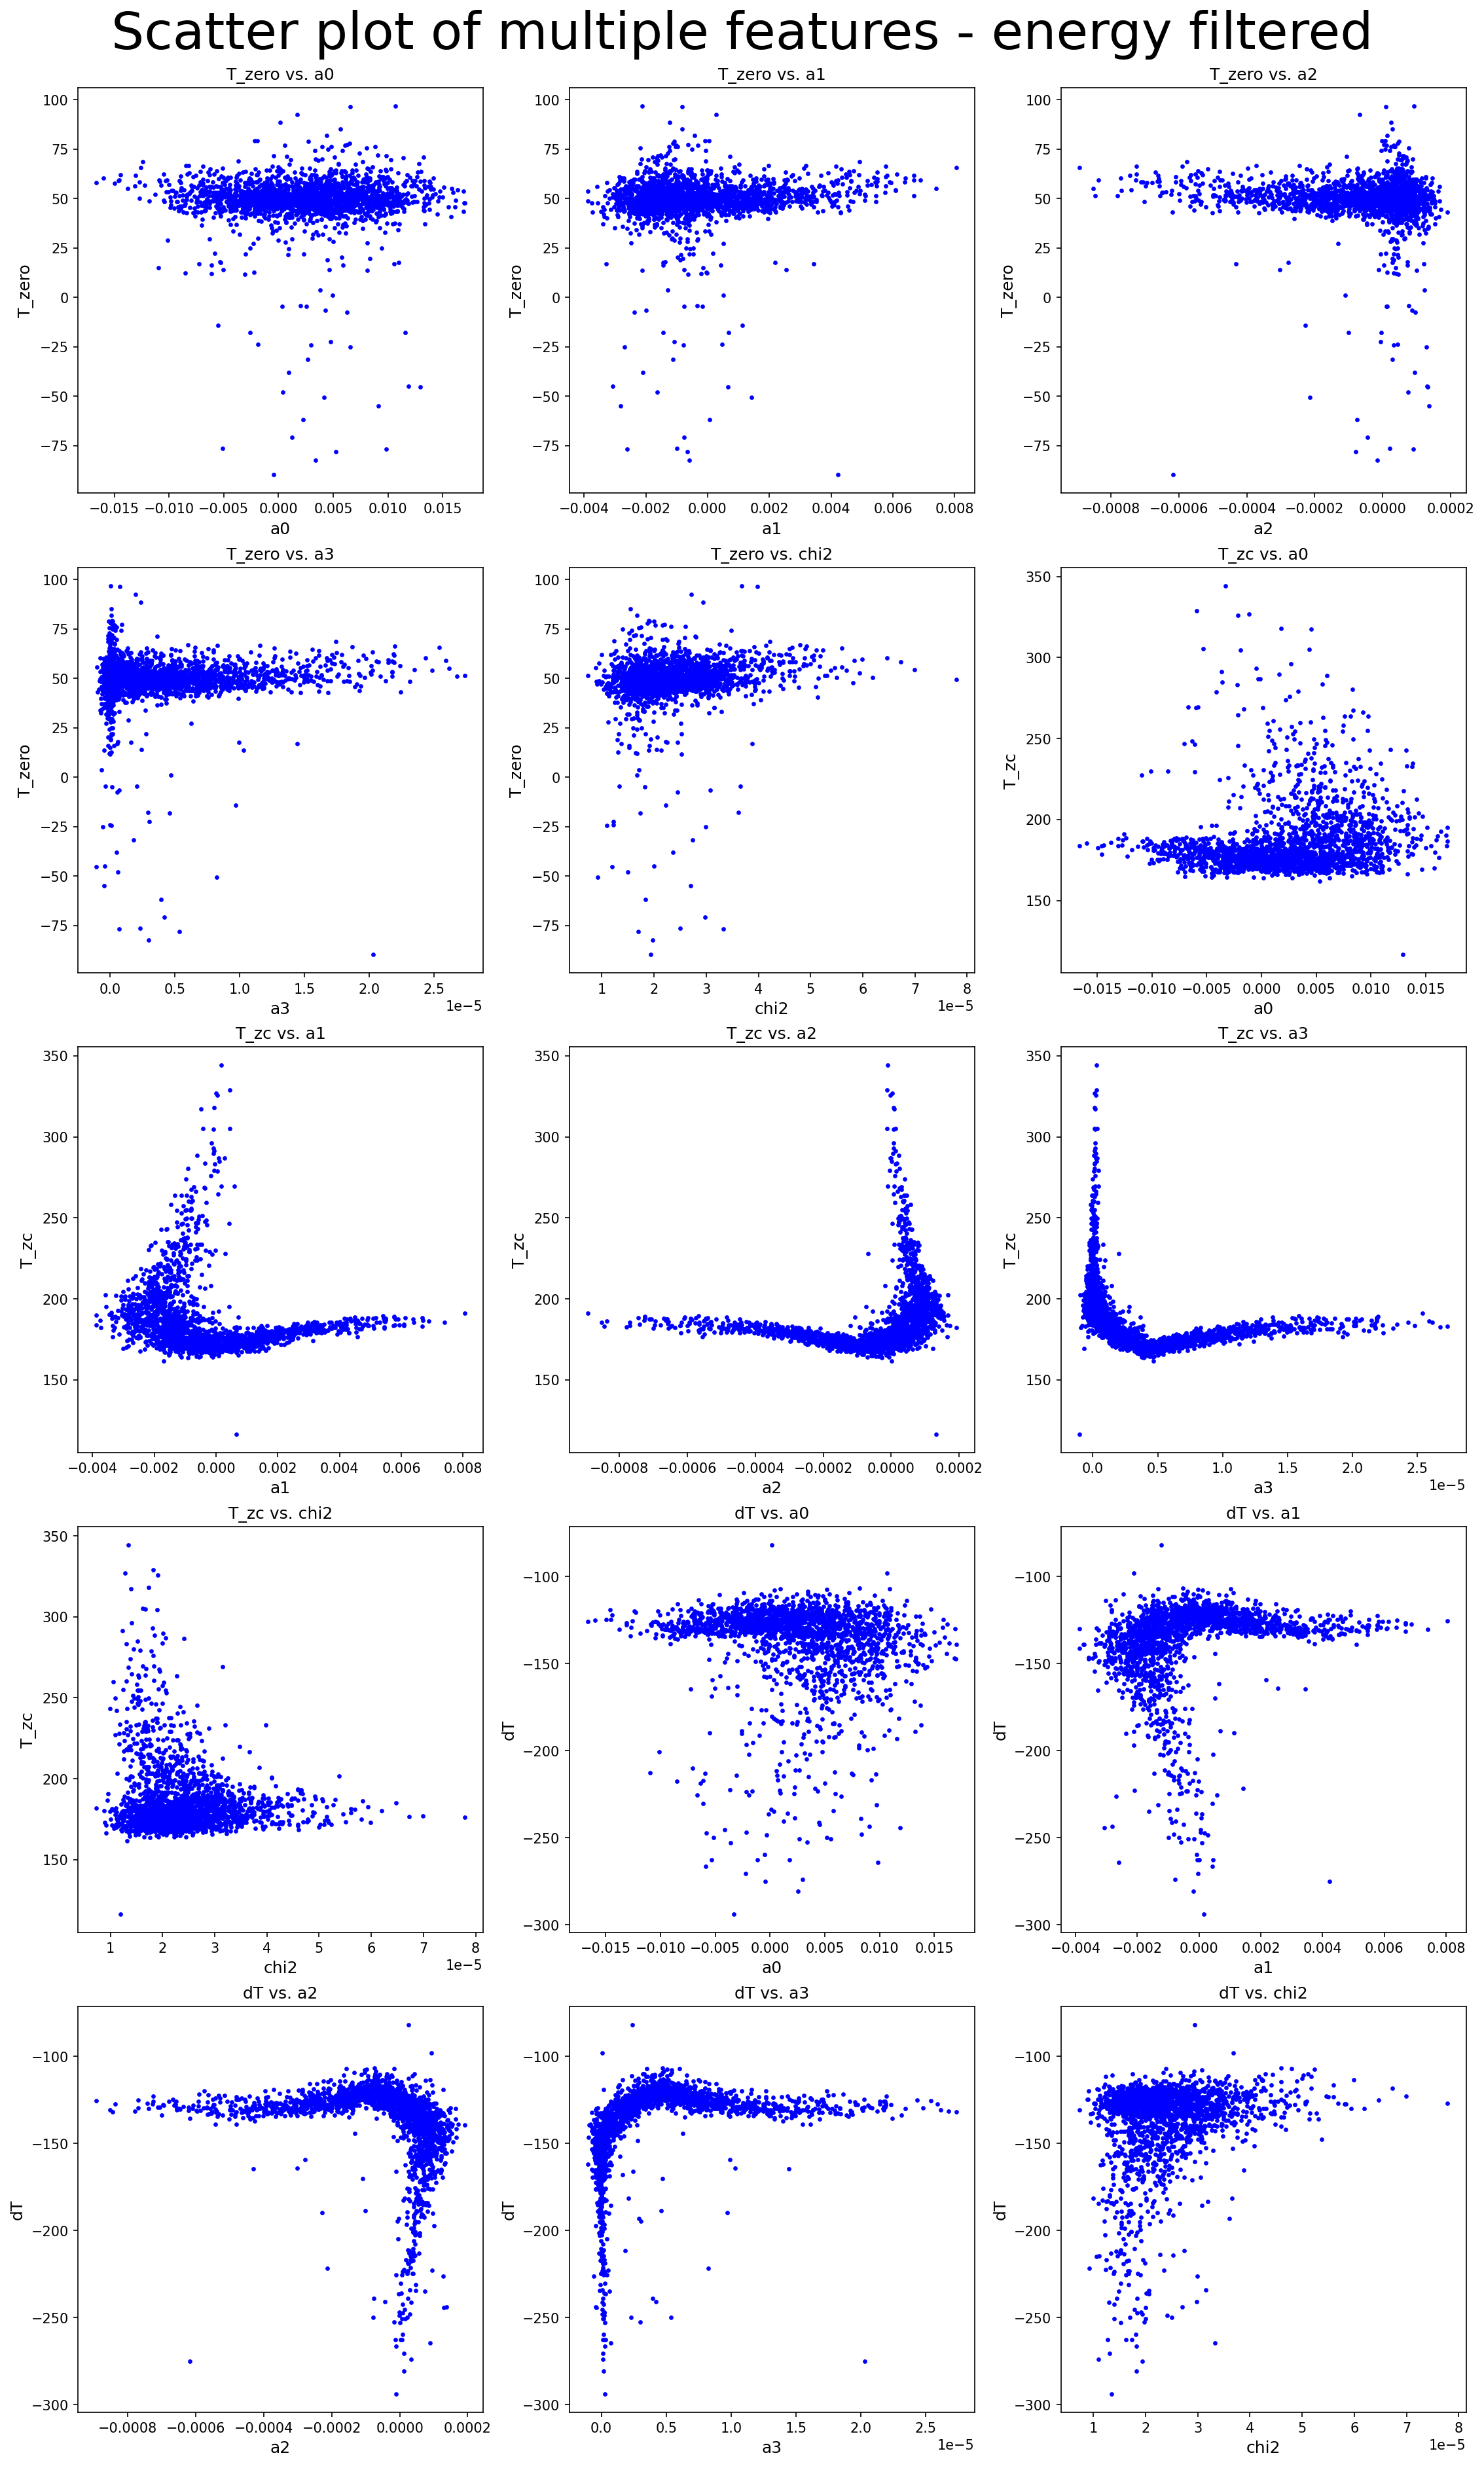

In [14]:
#--- Create scatter plot of only interesting features

x_features = ["a0", "a1", "a2", "a3", "chi2"]  # Training covariates - candidates
y_features = ["T_zero", "T_zc", "dT"]          # Response variables - candidates

# Create arrays with the names
x_names = x_features * len(y_features)
y_names = [y_features[0]] * len(x_features)

for i in range(1,len(y_features)):
    y_names = y_names + [y_features[i]] * len(x_features)
    
# The scatter plot
scatter_matrix_plotter(x_names, y_names, save_fig=True)

## Correlation between variables 

In [15]:
# Build correlation matrix
data_corr = data.corr(method="pearson")
# Convert to numpy array
data_corr_np = data_corr.to_numpy()

### Correlation Matrices

**Version 1**

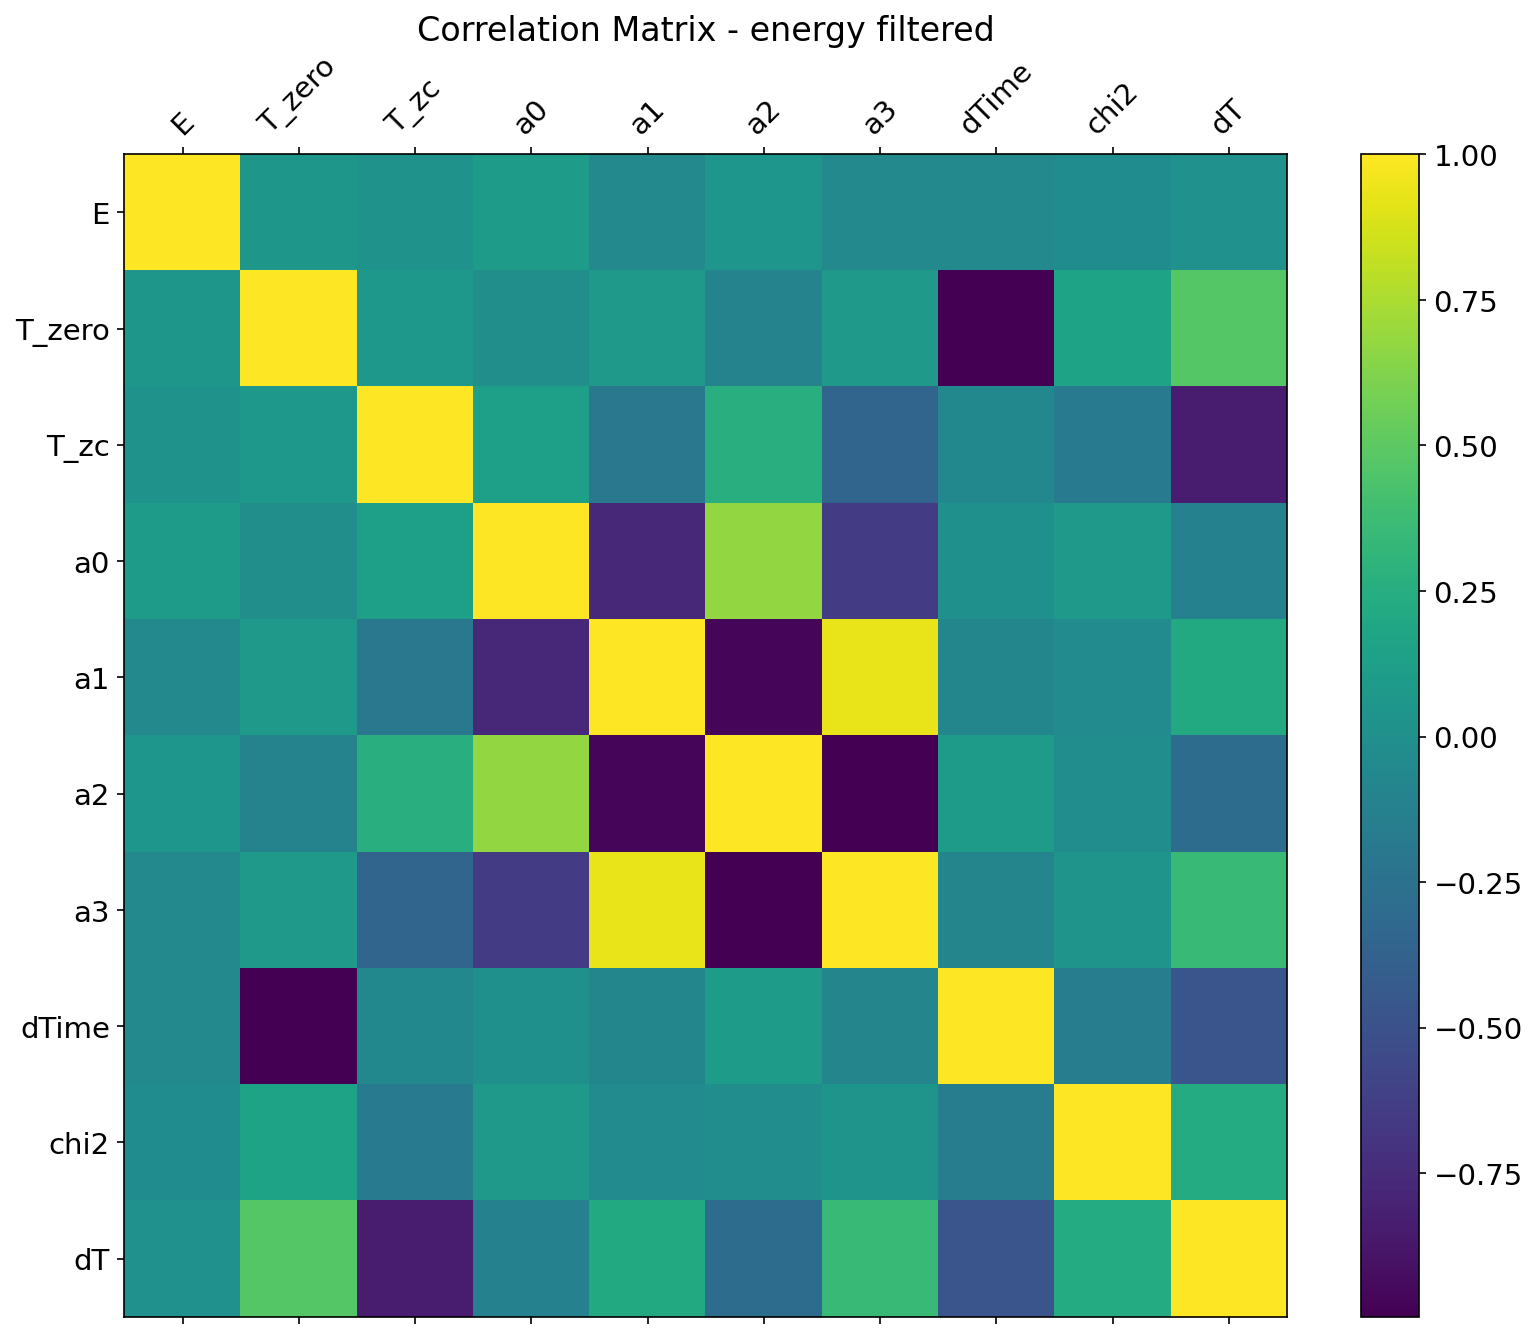

In [16]:
fig = plt.figure(figsize=(12.7, 10)) # 19 15

plt.matshow(data_corr, fignum=fig.number)

plt.xticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

if FILTER_ENERGIES == True:
    plt.title('Correlation Matrix - energy filtered', fontsize=16)
else:
    plt.title('Correlation Matrix - unfiltered.png', fontsize=16)

# Save figure. Put plt.show() after
if FILTER_ENERGIES == True:
    plt.savefig('Correlation Matrix - energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlation Matrix - unfiltered.png', bbox_inches='tight')
    
plt.show()

**Version 2**

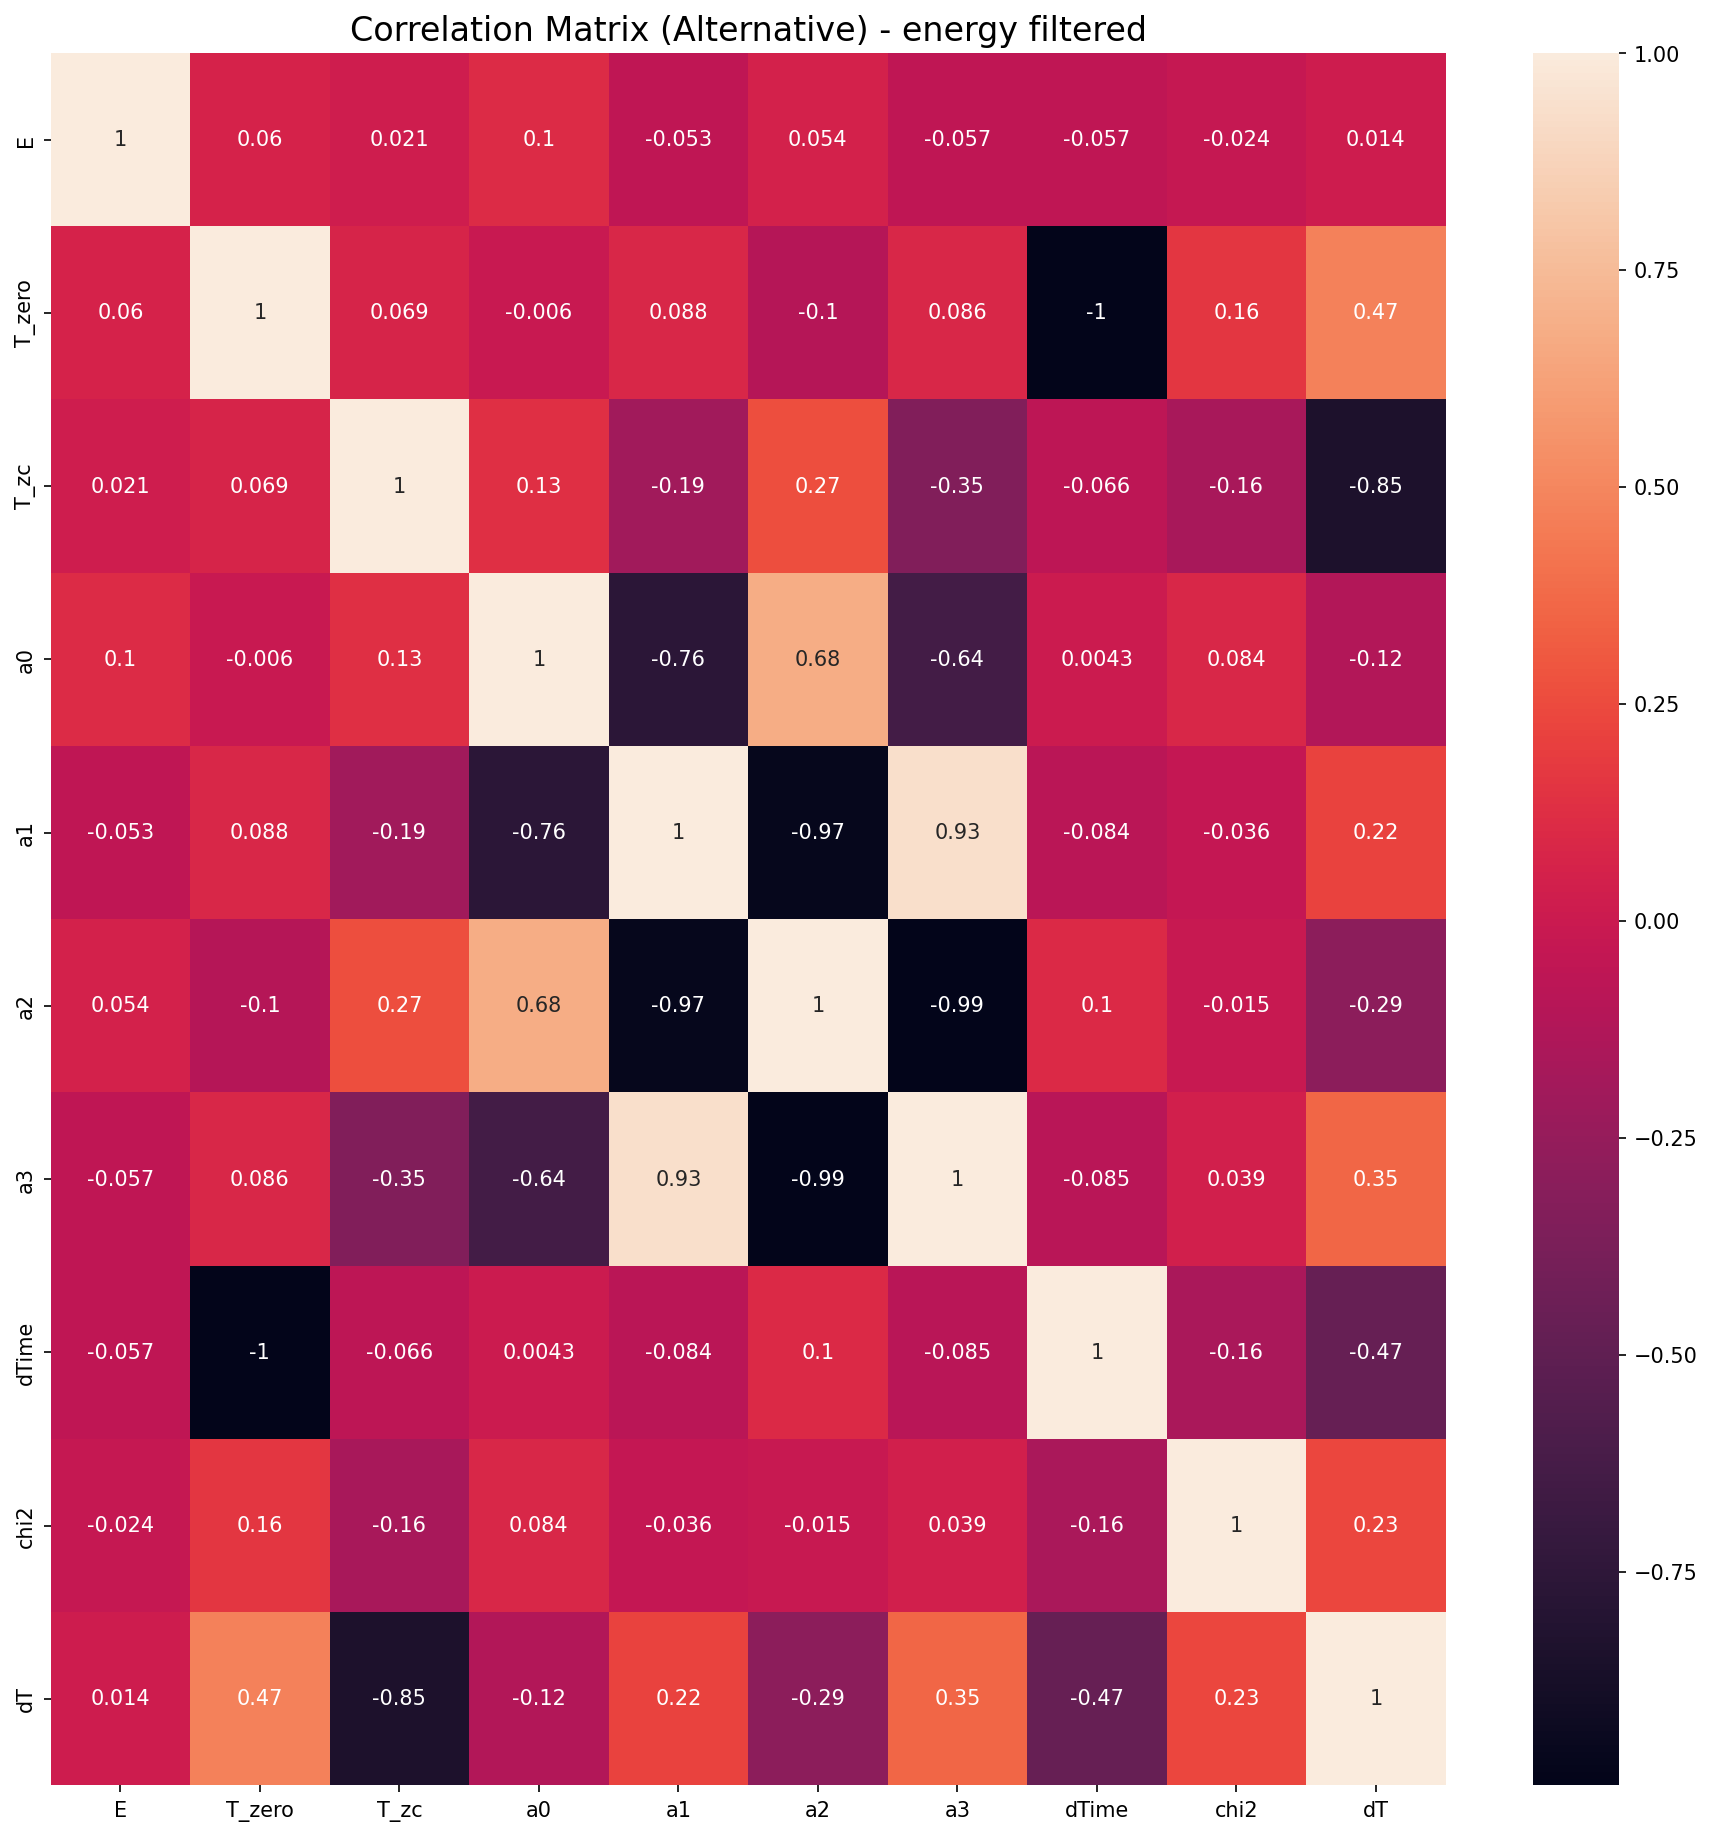

In [17]:
plt.figure(figsize=(15, 15))

ax = plt.subplot()

if FILTER_ENERGIES == True:
    ax.set_title('Correlation Matrix (Alternative) - energy filtered', fontsize=16)
else:
    ax.set_title('Correlation Matrix (Alternative) - unfiltered.png', fontsize=16)

sns.heatmap(data_corr, annot=True, ax = ax)

if FILTER_ENERGIES == True:
    plt.savefig('Correlation Matrix (Alternative) - energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlation Matrix (Alternative) - unfiltered.png', bbox_inches='tight')

### Pairwise Correlation

**Important Functions**

In [18]:
# --- Create a display function

# Treat columns as indices
# Use indices to refer back to the names
col_index= {i: c for i, c in enumerate(data_corr.columns)}

def correlation_plotter(ax, index=1, threshold=0, print_val=False,
                       zoom=False):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the correlation using the 'index' row. Additional features:
    
    - plots the absolute value only, but in different colors depending on the sign
    - prints the values and columns exceeding an imposed threshold
    - dynamically changes the scaling of the y axis for zooming in
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - index = Integer. It denotes the number of the row to be compared 
    with all other features. To see which column index corresponds to, 
    evaluate 'col_index[index]'
    - threshold = Float. It denoted the value to be exceeded by the
    absolute value of the correlations
    - print_val = Boolean. If true, it displays which columns exceed the
    threshold mentioned above
    - zoom = Boolean. If true, it dynamically changes the yrange such that
    one focuses only on values between 0 and roughly the maximum of the achieved
    correlations
    
    --- Returns:
    
    - axis is changed according to the specifications
    - if print_val=True, the columns above the threshold are printed
    """
    
    # Interested only in correlations excluding the variable itself
    mask = data_corr_np[index] < 1
    corr = data_corr_np[index][mask]  
    
    # xticks for plotting convenience
    xticks = np.array([1 + 3*i for i in range(len(corr))])
    
    # Separate the correlations via signs for different colors
    mask_pos = corr >= 0
    mask_neg = np.logical_not(mask_pos)
    
    corr_pos = corr[mask_pos]
    corr_neg = np.abs(corr[mask_neg])
    
    xticks_pos = xticks[mask_pos]
    xticks_neg = xticks[mask_neg]
    
    # Identify all points above the threshold
    if threshold > 0:
        _ = np.nonzero(np.abs(corr) > threshold)[0]
        # Offset values after the deleted index by 1
        # so it prints the correct column
        _[_ > index] += 1
        
        if print_val == True:
            if len(_) == 0:
                print(f"No correlations above {threshold}")
            else:
                print(f"{col_index[index]}. Columns over threshold: {[col_index[i] for i in _]}")
    
    # The plotting itself
    ax.set_title(f"Correlations - {col_index[index]}", fontsize=15)
    
    if threshold > 0:
        ax.hlines(y=threshold, xmin=0, xmax=xticks[-1] + 1, 
                  color="black", linestyle=":", label="Threshold")
    
    ax.scatter(xticks_pos, corr_pos, c="blue", s=5, label="Positive")
    ax.scatter(xticks_neg, corr_neg, c="red", s=5, label="Negative")

    ax.grid(axis='y')
    ax.legend(fontsize=8)

    ax.set_ylabel(f"{col_index[index]}", fontsize=12)
    ax.set_xlim(0, xticks[-1] + 1)
    
    # Dynamically change the yrange -- TO BE FIXED
    if zoom == True:
        ymax = min(1, 0.1*np.ceil(10 * np.max(np.abs(corr))))
        ax.set_ylim(0, ymax)
    else:
        ax.set_ylim(0, 1)
    
    _ = np.nonzero(np.logical_not(mask))[0][0] # Drop the removed variable from ticks
    ax.set_xticks(xticks, data_corr.drop(columns=[col_index[_]]).columns, fontsize=10, rotation=45)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    


In [6]:
col_index

{0: 'E',
 1: 'T_zero',
 2: 'T_zc',
 3: 'a0',
 4: 'a1',
 5: 'a2',
 6: 'a3',
 7: 'dTime',
 8: 'chi2',
 9: 'dT'}

dT. Columns over threshold: ['T_zero', 'T_zc', 'a0', 'a1', 'a2', 'a3', 'dTime', 'chi2']


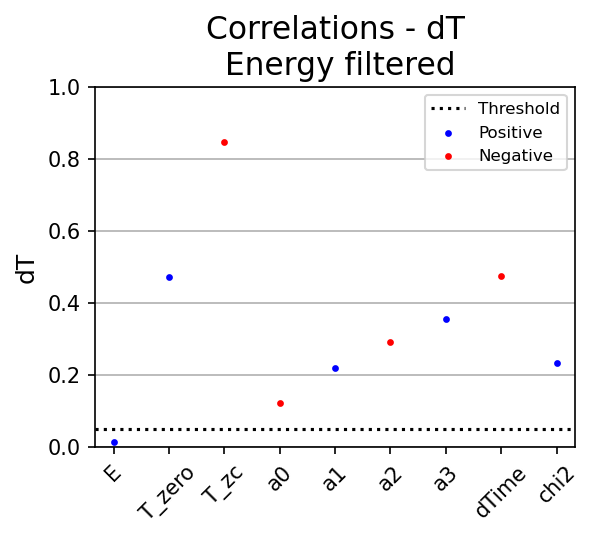

In [19]:
#-> Display correlations of dT versus the rest

# Index of dT
index = 9
# Correlation over 5%: say it's significant enough 
threshold = 0.05

#-> The figure

fig = plt.figure()
ax = fig.add_axes([0, 0, 0.5, 0.5])
correlation_plotter(ax, index=index, threshold=threshold, print_val=True, zoom=True)

if FILTER_ENERGIES == True:
    ax.set_title(f"Correlations - {col_index[index]}\n Energy filtered", fontsize=15)
else:
    ax.set_title(f"Correlations - {col_index[index]}\n Unfiltered", fontsize=15)
    
#-> Save figure

if FILTER_ENERGIES == True:
    plt.savefig('Correlations - dT vs all - Energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlations - dT vs all - Unfiltered.png', bbox_inches='tight')

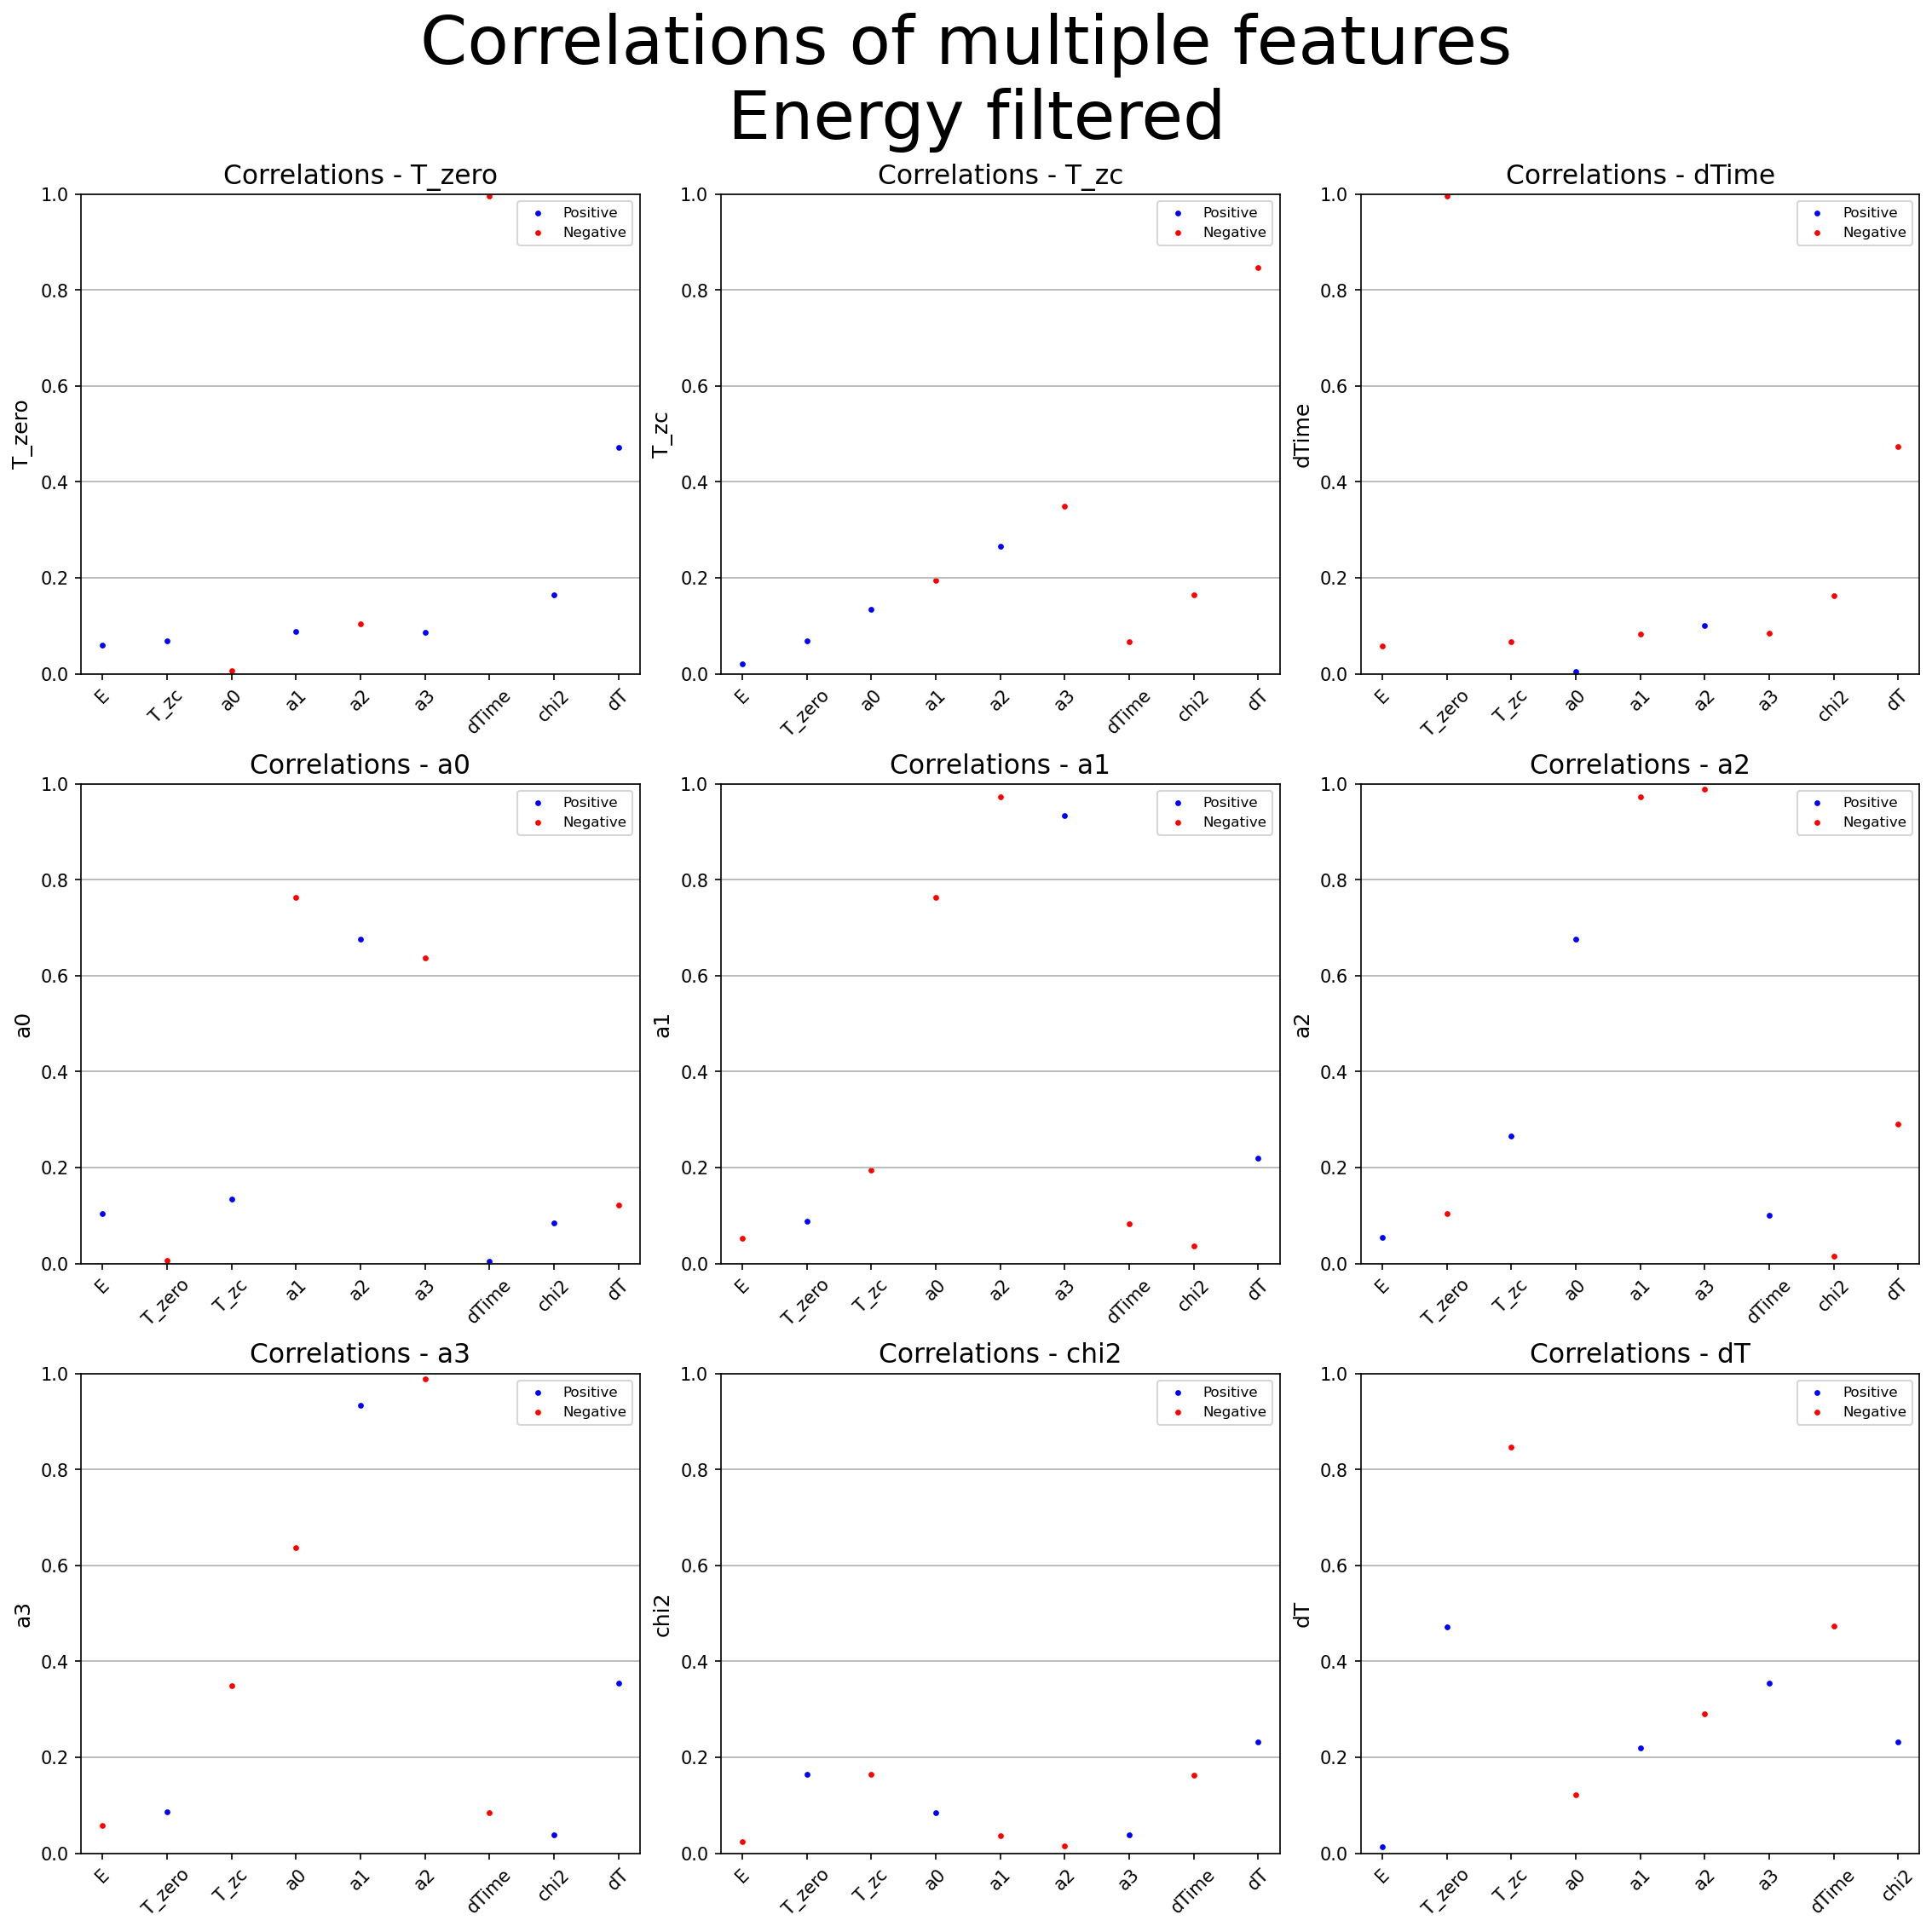

In [20]:
#-> Create subplots of correlations

# Define the indices where we want to analyze correlations
indices = [1, 2, 7, 3, 4, 5, 6, 8, 9]
num_rows = len(indices) // 3

fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

# Plot each correlation
for index, ax in zip(indices, axs.flatten()):
    correlation_plotter(ax, index=index)

if FILTER_ENERGIES == True:
    fig.suptitle('Correlations of multiple features\n Energy filtered', size=38)
else:
    fig.suptitle('Correlations of multiple features\n Unfiltered', size=38)

#-> Save figure

if FILTER_ENERGIES == True:
    plt.savefig('Correlations of multiple features - Energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlations of multiple features - Unfiltered.png', bbox_inches='tight')

plt.show()

# Training Models

**Select features and Split the data set**

- all: ["a0", "a1", "a2", "a3", "chi2"]
- coefficients only: ["a0", "a1", "a2", "a3"]
- high-order coefficients: ["a1", "a2", "a3"]

My model needs to have a resolution better than $\approx 25$ (i.e. the standard deviation of the residues is lower than the standard deviation of the raw label values). 

In [21]:
#--- Select features and convert to NP

def get_data_features(features_list, data_set=data,
                      test_size=0.3, random_state=42):
    """
    This function takes the pandas data frame 'data_set'
    and splits it into a training and a testing set.
    Only the features in 'features_list' are kept among
    the column of covariates.
    
    --- Inputs:
    
    features_list = list. It contains the columns of the covariates
    that will be kept for later training
    
    data_set = pandas data frame. The data set to be split
    
    test_size = float. The proportion of the data set that will
    be returned as a test set
    
    random_state = integer. The seed that is provided to the random
    splitting of the data set
    
    --- Outputs:
    
    list with 4 elements, each representing 
    X_train, X_test, Y_train, Y_test
    
    """
    
    # Change to the features list that I want to investigate
    Y = data_set[["dT"]]
    X = data_set[features_list]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=42)
    
    # To numpy
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    Y_train_np = Y_train.to_numpy()
    Y_test_np = Y_test.to_numpy()
    
    return [X_train_np, X_test_np, Y_train_np, Y_test_np]

In [22]:
features_list_list = [["a0", "a1", "a2", "a3", "chi2"],
                      ["a0", "a1", "a2", "a3"],
                      ["a1", "a2", "a3"]]

# To change the features you focus on, select another item
# in the list by changing 0 to another integer
features_list = features_list_list[0]

# Convert data in numpy format with given features
data_np = get_data_features(features_list)

# Extract output shape
input_shape_ = (len(features_list),)

In [23]:
data_np[0].shape, data_np[1].shape, data_np[2].shape, data_np[3].shape, input_shape_

((1393, 5), (598, 5), (1393, 1), (598, 1), (5,))

In [32]:
np.std(data_np[2]), np.std(data_np[3])

(24.61758294561333, 25.95819206173659)

**Important functions**

In [31]:
#--- Function to predict the values

def get_predictions(model, data=data_np,
                   plot_hist=False,
                   add_labelvals=False):
    """
    This function predicts both the training and the 
    test data, given a model. It can also plot a histogram
    of the predicted values against the label values.
    
    --- Inputs:
    
    model = tensorflow or sklearn object. It must be a model already
    defined and trained on the data, prior to calling
    this function
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**, which represent the data set on which the model was trained 
    on and on which it is to be tested. 
    Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    plot_hist = Boolean. If true, the function also returns
    a histogram plot of the predicted values, split into training
    and testing sets
    
    add_labelvals = Boolean. If true, to the above histogram the 
    histogram for the label values is also overlapped
    
    --- Returns:
    
    Matplotlib figure, if the option is enabled.
        
    (Yhat_train, Yhat_test) = A tuple with the predicted arrays
    for both train data and test data
    """
    
    # Obtain sizes
    N_train = len(data[2])
    N_test = len(data[3])
    N_total = N_train + N_test
    
    # Predict
    Yhat_train = model.predict(data[0])
    Yhat_test = model.predict(data[1])
        
    # Plot the histogram of predicted dT (and maybe label dTs)
    if plot_hist == True:       
        # Reshape arrays for plotting purposes
        Yhat_train_reshaped = Yhat_train.reshape((N_train,))
        Yhat_test_reshaped = Yhat_test.reshape((N_test,))
        Y_train_np_reshaped = data[2].reshape((N_train,))
        Y_test_np_reshaped = data[3].reshape((N_test,))

        # Plot
        fig = plt.figure(figsize=(5, 3))
        
        plt.hist(Yhat_train_reshaped, bins=N_total//80, alpha=0.5, color="r",
                 density=False, label="Predicted - train")
        
        plt.hist(Yhat_test_reshaped, bins=N_total//80, alpha=0.5, color="b",
                 density=False, label="Predicted - test")
        
        if add_labelvals == True:
            
            plt.hist(Y_train_np_reshaped, bins=N_total//100, alpha=0.5, color="green",
                     density=False, label="Label - train")
            
            plt.hist(Y_test_np_reshaped, bins=N_total//100, alpha=0.5, color="orange",
                     density=False, label="Label - test")
        
        if FILTER_ENERGIES == True:
            plt.title("Predicted dT values - energy filtered", fontsize=15)
        else:
            plt.title("Predicted dT values - unfiltered", fontsize=15)
            
        plt.xlabel("dT", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.legend()
        plt.show()
    
    return (Yhat_train, Yhat_test)

def get_residues(fitted_values, data=data_np,
                plot_residues=False, 
                test_norm=False):
    """
    This function computes the residues, which are defined as
    $$ y_{label, from data set} - \hat{y}_{prediction}$$
    
    It can also plot a histogram of the predicted values against 
    the label values, and test for the normality of the distribution of
    residues.
    
    --- Inputs:
    
    fitted_values = list or tuple. Its format is (Yhat_train, Yhat_test)
    as returned by get_predictions()
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**, which represent the data set on which the model was trained 
    on and on which it is to be tested. 
    Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    plot_residues = the histogram of residues for predicted and
    label data
    
    test_norm = applies a normality test to see if the residues are
    normally distributed. The closer to normality they are, the better
    the initial prediction.
    
    --- Returns:
    
    Matplotlib figure, if the option is enabled.
        
    (residue_train, residue_test) = A tuple with the arrays of residues
    for both train data and test data
    """
    
    # Obtain predictions
    Yhat_train, Yhat_test = fitted_values
    
    # Obtain sizes
    N_train = len(data[2])
    N_test = len(data[3])
    N_total = N_train + N_test
    
    # Compute residues
    residue_train = data[2] - Yhat_train
    residue_test = data[3] - Yhat_test
    
    # Plot the histogram of residues
    if plot_residues == True:
        # Reshape arrays for plotting purposes
        residue_train_reshaped = residue_train.reshape((N_train,))
        residue_test_reshaped = residue_test.reshape((N_test,))
        
        # PLot
        fig = plt.figure(figsize=(5, 3))
        
        plt.hist(residue_train_reshaped, bins=N_total//100, alpha=0.3,
                 density=True, color="b", label="Train")
        
        plt.hist(residue_test_reshaped, bins=N_total//100, alpha=0.3,
                 density=True, color="r", label="Test")
        
        if FILTER_ENERGIES == True:
            plt.title("Residue distribution - energy filtered", fontsize=15)
        else:
            plt.title("Residue distribution - unfiltered", fontsize=15)
        
        plt.xlabel("Residue", fontsize=12)
        plt.ylabel("Normalized frequency", fontsize=12)
        plt.legend()
        plt.show()
    
    # Normal Test
    if test_norm == True:
        pval_train = sps.normaltest(residue_train).pvalue
        pval_test = sps.normaltest(residue_test).pvalue
        
        print(f"p-value for normality of train: {pval_train}")
        print(f"p-value for normality of test: {pval_test}\n")
    
    return (residue_train, residue_test)

def get_resolutions(residues,
                  method="std"):
    """
    The function returns the resolution of the predictions
    for both the training and the testing data sets.
    
    The resolution can be defined in multiple ways:
    - as the standard deviation of all residues ("std")
    - as the mean of the absolute value of all residues ("mean")
    
    --- Inputs:
    
    residues = A tuple with the arrays of residues
    for both train data and test data. 
    Note: = the return of get_residues()
    
    method = string. It determines which definition is applied when 
    finding the resolution. See the definitions above for the options
    
    --- Outputs:
    
    A tuple (resolution_train, resolution_test) containing the resolutions
    for both the training and the testing sets.
    """
    
    # Resolutions
    if method == "std":
        resolution_train = np.std(residues[0])
        resolution_test = np.std(residues[1])
        
        return (resolution_train, resolution_test)
    
    elif method == "mean":
        resolution_train = np.mean(np.abs(residues[0]))
        resolution_test = np.mean(np.abs(residues[1]))
        
        return (resolution_train, resolution_test)
    
    else:
        print("Invalid method!")
        return (np.inf, np.inf)

#--- Define joint function for ease of implementation:

def predictor(model, data=data_np,
              plot_hist=False,  
              add_labelvals=False,
              plot_residues=False,
              test_norm=False,
              add_resolutions=False,
              method='std'):
    """
    This function provides an integrated API for calling
    all three of the functions above. Mainly for comfort 
    purposes.
    
    --- Inputs:
    
    model = tensorflow or sklearn object. It must be a model already
    defined and trained on the data, prior to calling
    this function
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**, which represent the data set on which the model was trained 
    on and on which it is to be tested. 
    Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    plot_hist = Boolean. If true, the function also returns
    a histogram plot of the predicted values, split into training
    and testing sets
    
    add_labelvals = Boolean. If true, to the above histogram the 
    histogram for the label values is also overlapped
    
    plot_residues = the histogram of residues for predicted and
    label data
    
    test_norm = applies a normality test to see if the residues are
    normally distributed. The closer to normality they are, the better
    the initial prediction.
    
    add_resolutions = Boolean. If true, it prints nicely the 
    resolutions corresponding to each data set (train/test).
    
    method = string. It determines which definition is applied when 
    finding the resolution. See the definitions above for the options
    
    --- Outputs:
    
    Depending on which boolean is set to true, it returns 
    figures or printed statements.
    """
    
    # Predict the data
    predictions = get_predictions(model, data=data, plot_hist=plot_hist,
                                 add_labelvals=add_labelvals)
    # Compute residues
    residues = get_residues(predictions,
                            plot_residues=plot_residues, test_norm=test_norm)
    
    # Find resolution
    if add_resolutions == True:
        resolutions = get_resolutions(residues, method=method)
        
        print(f"Method: {method}")
        print(f"Resolution - train set: {resolutions[0]}")
        print(f"Resolution - test set: {resolutions[1]}")

## Neural Networks Regression

**Functions that generate, train and save Sequential NN models**

In [28]:
#--- Define function to create a model

def get_model(nodes_per_layer: list,
             input_shape: tuple = input_shape_,
             hidden_layer_activation: str = 'relu',
             num_nodes_at_output: int = 1,
             output_layer_activation: str = 'linear'):
    """
    This function creates a tensorflow (keras) sequential model,
    but without actually compiling the model. 
    
    --- Input:
    
    nodes_per_layer = list. It gives the number of nodes that 
    each layer will have, in order. Its length is the number of 
    hidden layers
    
    input_shape = tuple. It gives the shape of the input layer;
    It is of the form (#Features,) - ignoring the number of data
    points
    
    hidden_layer_activation = string. It gives the activation function
    of the hidden layers. 
    
    num_nodes_at_output = integer. It gives the number of nodes that
    the output layer has
    
    output_layer_activation = string. It gives activation function of the
    output layer. By default it is set to 'linear', which is appropriate
    for a regression task
    
    --- Output:
    
    model = keras.src.engine.sequential.Sequential. A non-compiled
    tensorflow sequential model
    """
    
    # Create sequential model
    model = tf.keras.Sequential()
    
    # Change name for ease of tracking
    if FILTER_ENERGIES == True:
        model_name = 'filtered_'
    else:
        model_name = 'unfiltered_'
    
    model_name += hidden_layer_activation + '_'
    
    # Add input layer
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    # Add the hidden layers
    for nodes in nodes_per_layer:
        model.add(tf.keras.layers.Dense(nodes, activation=hidden_layer_activation))
        # Append to name
        model_name += f'{nodes}_'
    
    # Add output layer
    model.add(tf.keras.layers.Dense(num_nodes_at_output, activation=output_layer_activation))
    
    # Set the name of the model
    model._name = model_name[:-1]
    
    return model

#--- Define function to create many models:

def get_models(nodes_per_layer_list: list,
               input_shape: tuple = input_shape_,
               hidden_layer_activation: str = 'relu',
               num_nodes_at_output: int = 1,
               output_layer_activation: str = 'linear'):
    """
    The function generates a list of models, as created by the
    get_model() function. The only difference is that now each 
    model will have nodes_per_layer as given by the elements of 
    nodes_per_layer_list.
    """
    
    # Create a list of models   
    models = []
    
    for nodes_per_layer in nodes_per_layer_list:
        temp = get_model(nodes_per_layer, input_shape=input_shape,
                        hidden_layer_activation=hidden_layer_activation,
                        num_nodes_at_output=num_nodes_at_output,
                        output_layer_activation=output_layer_activation)
        models.append(temp)
    
    return models

#--- Function to train a model

def train(model, 
         data=data_np,
         loss=tf.keras.losses.mse,
         optimizer=tf.keras.optimizers.Adam(),
         metrics=['mse'],
         batch_size=None):
    """
    The function compiles and trains a tf sequential
    model to the training data data.
    
    --- Inputs:
    
    model = tf.sequential.Sequential object. The tensor
    flow model to be modified
    
    data = list. It consists of a list [X, Y] containing the 
    training data and testing data. See predictor() for details
    
    loss, optimizer = tf.keras objects. They represent the 
    loss function and the optimizer to be used when training
    - For more on optimizers, check the following link:
    https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
    - Learning rate: It roughly represents the size of the
    steps when searching for the minimum of the loss function.
    The exact interpretation depends on the optimizer
    - To change the learning rate, call 
    train(..., optimizer=your_function(learning_rate=chosen_float))
    
    metrics = list. It is a list contaning a string with the
    metric that is optimized when fitting the function. An 
    alternative to this is ['mae'].
    
    batch_size = Integer or None. Number of samples per gradient update,
    used to do backpropagation in gradient descent.
    If unspecified, batch_size will default to 32.
    See the following link for more details, at the .fit() method:
    https://www.tensorflow.org/api_docs/python/tf/keras/Model
    
    --- Outputs:
    
    None. The model in the argument is modified and fitted
    """
    
    # Compile the model
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    
    # Fit the model - distinguish if batch_size is provided or not
    if(type(batch_size) == int):
        model.fit(data[0], data[2], epochs=100, verbose=0,
                 batch_size=batch_size)
    else:
        model.fit(data[0], data[2], epochs=100, verbose=0)
        
#--- Functions that save or load a trained model

def save_model(model, 
        path_folder=paths_on_my_laptop[1]):
    """
    This function saves a given tensorflow model in the folder
    given by the path 'path_folder'
    
    Inspired from:
    https://www.tensorflow.org/guide/keras/serialization_and_saving
    
    --- Returns:
    
    Besides saving the model, the function returns the path of the 
    saved file, including its name and '.keras' extension
    """
    
    # Save
    path_file = path_folder + model.name + '.keras'

    model.save(path_file)
    
    return path_file

def load_model(path_file):
    """
    This function loads a tensorflow model
    given by the path 'path_file'
    
    Inspired from:
    https://www.tensorflow.org/guide/keras/serialization_and_saving
    
    --- Returns:
    
    Tensorflow model. It should already be defined, compiled and fitted 
    to the training data; ready to use for predictions
    """
    
    # Load
    return tf.keras.models.load_model(path_file)

#--- Define a function to create layer-node permutations:

def get_layer_node_permutations(num_layers: int,
               min_nodes_per_layer: int,
               max_nodes_per_layer: int,
               node_step_size: int):
    """
    In mathematical terms, the function generates the cartesian
    product of the set A = range(min_nodes, max_nodes + 1, step_size)
    repeated num_layers times:
    
    A X A X A X ... X A
    
    --- Inputs:
    
    num_layers = Integer. It gives the number of nodes that 
    each layer will have, in order. Its length is the number of 
    hidden layers. In this context: the number of times we take the
    cartesian product
    
    min_nodes_per_layer = Integer. The minimal number of nodes a layer
    is allowed to have.
    
    max_nodes_per_layer = Integer. The maximal number of nodes a layer
    is allowed to have (inclusive).
    
    node_step_size = Integer. The spacing between allowed number of nodes
    
    --- Returns:
    
    A list of tuples. Each tuple consists of a permutation of num_layers
    elements samples from the set A.
    
    --- Example:
    
    get_layer_node_permutations(2, 5, 7, 1)
    > [(5, 5), (5, 6), (5, 7), (6, 5), (6, 6), (6, 7), (7, 5), (7, 6), (7, 7)]
    """
    
    # Possible number of nodes
    node_options = list(range(min_nodes_per_layer, max_nodes_per_layer+1, node_step_size))
    
    # Repeat the above num_layers times
    layer_possibilities = [node_options] * num_layers
    
    # Generate permutations of the above 
    # = all possible arrangements of number of nodes per layer
    layer_node_permutations = list(itertools.product(*layer_possibilities))
    
    return layer_node_permutations

### Test the functions

In [29]:
model_test = get_model([10, 10, 10, 10, 10, 10, 10],
                     hidden_layer_activation='relu')
train(model_test,optimizer=tf.keras.optimizers.Adam())
model_test.summary()



Model: "filtered_relu_10_10_10_10_10_10_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (

19/19 [==============================] - 0s 1ms/step


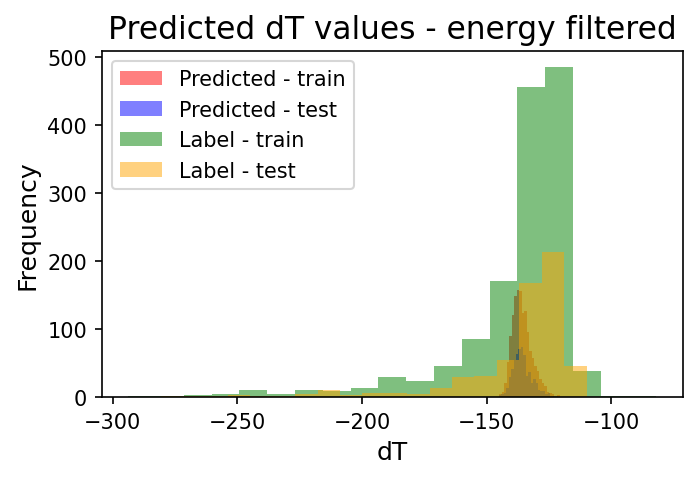

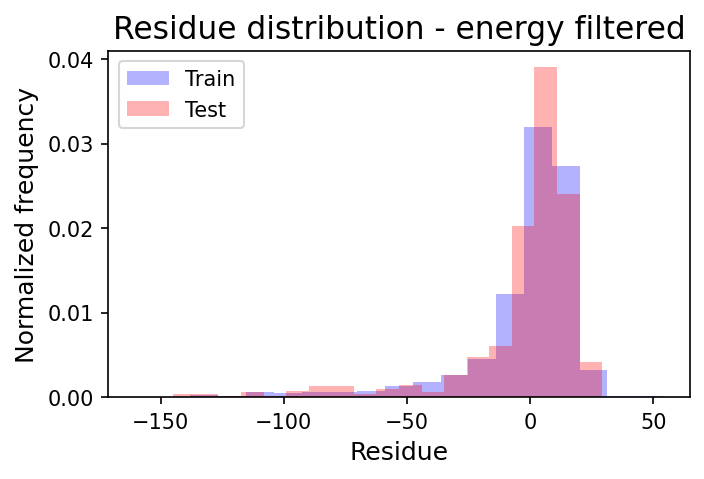

Method: std
Resolution - train set: 24.156112120380847
Resolution - test set: 25.629844451764754


In [33]:
predictor(model_test, plot_hist=True, plot_residues=True,
          add_labelvals=True, add_resolutions=True,)

In [34]:
path_file = save_model(model_test)
path_file

'C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/Saved Models/filtered_relu_10_10_10_10_10_10_10.keras'

In [35]:
model_test = load_model('C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/Saved Models/filtered_relu_10_10_10_10_10_10_10.keras')
model_test.summary()

Model: "filtered_relu_10_10_10_10_10_10_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (No

### Optimize Model Architecture